In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel
import matplotlib.pyplot as plt
from functions import *

In [2]:
class LLM(nn.Module):
    def __init__(self, inputSize, hiddenSize, layers):
        super(LLM, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.ReLU(), # CHANGE AS NECESSARY
            *[nn.Sequential(nn.Linear(hiddenSize, hiddenSize), nn.ReLU()) for _ in range(layers)],
            nn.Linear(hiddenSize, 1)
        )
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.layers = layers
        
    def forward(self, x):
        return self.model(x)

inputs = tensor([[1., 2., 3., 4., 5.],
        [2., 3., 4., 5., 6.],
        [3., 4., 5., 6., 7.],
        [4., 5., 6., 7., 8.]])
Early Stopping at Epoch 469
Predicted next number: 10.38


Text(0, 0.5, 'MSE')

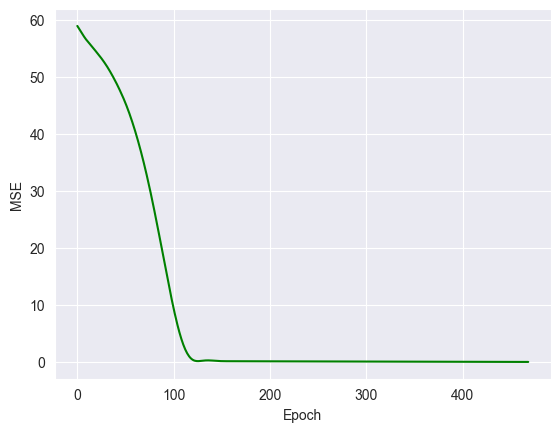

In [3]:
# Initialize the model
input_size = 5  # Number of previous numbers in the sequence
hidden_size = 128
num_layers = 3
model = LLM(input_size, hidden_size, num_layers)
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
data = [
    ([1, 2, 3, 4, 5], 6),
    ([2, 3, 4, 5, 6], 7),
    ([3, 4, 5, 6, 7], 8),
    ([4, 5, 6, 7, 8], 9),
]

# Convert data to tensors
inputs = torch.tensor([item[0] for item in data], dtype=torch.float32)
targets = torch.tensor([item[1] for item in data], dtype=torch.float32).unsqueeze(1)
print(f'inputs = {inputs}')

# Training loop
epochs = 1000
losses = []
for epoch in range(epochs):
    # Forward pass
    predictions = model(inputs)
    loss = lossFunction(predictions, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    losses.append(loss)
    if loss < 1e-2:
        print(f'Early Stopping at Epoch {epoch+1}')
        break
# Test the model
test_input = torch.tensor([[5, 6, 7, 8, 9]], dtype=torch.float32)
predicted_output = model(test_input).item()
print(f"Predicted next number: {predicted_output:.2f}")
pd.Series(losses).plot(color='green')
plt.xlabel('Epoch')
plt.ylabel('MSE')

# Try the NN for the full data

In [4]:
data, X, y = setup('BTC')
data

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,Username,Text,Created_at,Tweet_ID,coin,sentiment_tweet_roberta,score_filtered,date_filtered,gradient,TextType
0,2024-04-18,60816.07,64210.00,61275.73,63513.85,15249.842114,2238.12,3.652539,63384.6340,65477.6480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,tweet
1,2024-04-19,59573.32,65498.99,63514.84,63848.37,22838.079342,333.53,0.525121,63267.4180,65593.8616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.52,tweet
2,2024-04-20,63121.15,65463.08,63841.96,64968.87,5157.407265,1126.91,1.765156,63228.6780,65702.9752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1120.50,newspaper
3,2024-04-21,64250.00,65725.81,64960.82,64952.92,4487.487232,-7.90,-0.012161,63019.6080,65796.3552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.95,tweet
4,2024-04-22,64520.00,67272.73,64952.92,66859.17,10977.051786,1906.25,2.934818,62812.6935,65887.2514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906.25,tweet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper
433,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper
434,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper
435,2025-04-16,83088.02,85526.40,83622.52,84028.72,8243.059013,406.20,0.485754,65573.5735,66024.8888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,newspaper


In [5]:
def sequence(column, index):
    if index < len(column):
        return column.values[:index].tolist(), column.values[index+1]
    raise ValueError(f'Index = {index} ≥ Length = {len(column)}')

sequences = []
for i in range(len(data)-1):
    sequences.append(sequence(data['gradient'], i))
sequences.append(([], np.NaN))
data['list'] = [i[0] for i in sequences]
data['next'] = [i[1] for i in sequences]
data[['gradient', 'list', 'next']]

,gradient,list,next
0,0.00,[],334.52
1,334.52,[0.0],1120.50
2,1120.50,"[0.0, 334.5200000000041]",-15.95
3,-15.95,"[0.0, 334.5200000000041, 1120.5]",1906.25
4,1906.25,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",-445.01
...,...,...,...
432,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",0.00
433,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",0.00
434,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",0.00
435,0.00,"[0.0, 334.5200000000041, 1120.5, -15.950000000...",1199.35


### Fit the model on the list and next

In [6]:
# First, check if there are empty lists
empty_lists = data['list'].apply(lambda x: len(x) == 0)
print(f"Number of empty lists: {empty_lists.sum()}")

# Filter out rows with empty lists
filtered_data = data[~empty_lists].copy()

# Option 1: If all lists should be the same length
# Get the expected length
expected_length = input_size  # Using the model's input_size (5)

# Filter lists with the right length
valid_rows = filtered_data['list'].apply(lambda x: len(x) == expected_length)
filtered_data = filtered_data[valid_rows].copy()

# Convert to tensor
inputs = torch.tensor(filtered_data['list'].tolist(), dtype=torch.float32)
targets = torch.tensor(filtered_data['next'].tolist(), dtype=torch.float32).unsqueeze(1)

print(f"Shape of inputs tensor: {inputs.shape}")
print(f"Shape of targets tensor: {targets.shape}")

Number of empty lists: 2
Shape of inputs tensor: torch.Size([1, 5])
Shape of targets tensor: torch.Size([1, 1])


In [7]:
epochs = 1000
losses = []
for epoch in range(epochs):
    # Forward pass
    predictions = model(inputs)
    loss = lossFunction(predictions, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    losses.append(loss)
    if loss < 1e-2:
        print(f'Early Stopping at Epoch {epoch+1}')
        break

Early Stopping at Epoch 202
